# Can we predict a failure by looking at the SMART metrics ?

### As already claimed, our goal is to sustain planned checking and controls (offline) with predictive maintenance (online). These predictions should depend on the evolution of the SMART metrics, but how do we know whether fluctuations of these metrics and failures are correlated?

After running the notebook "DataWrangling_1_Models", we have a folder with data associated to a specific model, ex: 'Hitachi HDS722020ALA330'. Let us read those files and explore this dataset.

Note: The dataset we analyze is manageable with a 4-Core, 8GB Ram personal laptop for every hard disk model but 'ST4000DM000' which would require a larger memory.

In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the dataset associated to a specific model:  (ex:'Hitachi HDS722020ALA330', 'ST8000DM002')

#ModelName = 'ST8000DM002' 
ModelName = 'Hitachi HDS722020ALA330' 

folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

df15 = pd.read_csv(folder_name + '/Model_15.csv')
df16 = pd.read_csv(folder_name + '/Model_16.csv')
df17 = pd.read_csv(folder_name + '/Model_17.csv')

df15['date'] = pd.to_datetime(df15['date'])
df16['date'] = pd.to_datetime(df16['date'])
df17['date'] = pd.to_datetime(df17['date'])

# Concatenate the yearly datasets in an unique pandas DataFrame : df

df = pd.concat([df15,df16,df17], ignore_index=True)

del df15
del df16
del df17

del df['Unnamed: 0']  #### Why this column is there?

df.describe()

,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_5_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized
count,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06
mean,5.827781e-05,9.970960e+01,1.030739e+02,1.186466e+02,9.995405e+01,1.019221e+02,9.969824e+01,9.969824e+01,2.067698e+02,9.995118e+01
std,7.633769e-03,1.643947e+00,9.510941e+00,6.701817e+00,1.190153e+00,6.035827e+00,6.207148e-01,6.207148e-01,3.054345e+01,1.220344e+00
min,0.000000e+00,1.000000e+00,1.000000e+02,1.000000e+02,5.000000e+00,4.600000e+01,6.800000e+01,6.800000e+01,1.150000e+02,4.000000e+00
25%,0.000000e+00,1.000000e+02,1.000000e+02,1.150000e+02,1.000000e+02,1.000000e+02,9.900000e+01,9.900000e+01,1.870000e+02,1.000000e+02
50%,0.000000e+00,1.000000e+02,1.000000e+02,1.160000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.060000e+02,1.000000e+02
75%,0.000000e+00,1.000000e+02,1.000000e+02,1.200000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.300000e+02,1.000000e+02
max,1.000000e+00,1.000000e+02,1.350000e+02,2.530000e+02,1.000000e+02,1.230000e+02,1.000000e+02,1.000000e+02,2.530000e+02,1.000000e+02


In [3]:
# Extract the data associated to each hard disk: whether it will fail, the first, and the last entry   

df_failed = df.groupby('serial_number').failure.sum()
df_last_app = df.groupby('serial_number').date.max()
df_first_app = df.groupby('serial_number').date.min()


# Data in the days of failures : verify that the last entry of a failing hard-disk coincides with a failure
df_failure_days = df.loc[df['failure']==1,['date','serial_number']]
df_failure_days.index = df_failure_days['serial_number']

del df_failure_days['serial_number']

# Generate a DataFrame with data associated to each serial number    
df_serialnumber = pd.concat([df_failed, df_first_app, df_last_app, df_failure_days], axis = 1)
df_serialnumber.columns = ['failure', 'date_first', 'date_last', 'date_failure']

# ... check whether the last entry of a failing hard-disk coincides with a failure
df_serialnumber['failure_wrong'] = df_serialnumber.failure * (df_serialnumber.date_last != df_serialnumber.date_failure)
df_serialnumber['failure_correct'] = df_serialnumber.failure * (1 - df_serialnumber.failure_wrong)

del df_failed
del df_last_app
del df_first_app
del df_failure_days

del df_serialnumber['failure_wrong']

# We now determine whether each serial_number is going to fail, will remain healthy, or is a wrong entry
dictionary_serial_number_state ={ (1,1): 'fail',
                                  (0,0): 'healthy',
                                  (1,0): 'wrong' }

df_serialnumber['state'] = [ dictionary_serial_number_state[(df_serialnumber.loc[s_n,'failure'],df_serialnumber.loc[s_n,'failure_correct'])] for s_n in df_serialnumber.index]

del df_serialnumber['failure']
del df_serialnumber['failure_correct']

# In the example with ModelName = 'Hitachi HDS722020ALA330', we have one wrongly reported hard-disk: 'JK1101B9JPJ4NF' 
df_serialnumber[df_serialnumber['state'] == 'wrong']

,date_first,date_last,date_failure,state
JK1101B9JPJ4NF,2015-01-01,2016-08-04,2015-03-30,wrong


In [5]:
# Add a column to the main df stating whether the entry belongs to a failing hard-disk: 1 or not: 0
df['state'] = df.serial_number.apply(lambda x : df_serialnumber.state[x])

# The dataset has a natural structure with a 2-levels indexing :
# 1) The outer level captures a specific hard-disk (identified by the serial_number) ;
# 2) The inner level captures the TimeStamp of the recording. 

df = df.set_index(['serial_number','date']).sort_index()

df.head()

failure  smart_1_normalized  smart_2_normalized  \
serial_number  date                                                          
JK1100B8G3B7AT 2015-01-01        0               100.0               100.0   
               2015-01-02        0               100.0               100.0   
               2015-01-03        0               100.0               100.0   
               2015-01-04        0               100.0               100.0   
               2015-01-05        0               100.0               100.0   

                           smart_3_normalized  smart_5_normalized  \
serial_number  date                                                 
JK1100B8G3B7AT 2015-01-01               116.0               100.0   
               2015-01-02               116.0               100.0   
               2015-01-03               116.0               100.0   
               2015-01-04               116.0               100.0   
               2015-01-05               116.0               100.0   

                           smart_8_normalized  smart_192_normalized  \
serial_number  date                                                   
JK1100B8G3B7AT 2015-01-01               100.0                 100.0   
               2015-01-02               100.0                 100.0   
               2015-01-03               100.0                 100.0   
               2015-01-04               100.0                 100.0   
               2015-01-05               100.0                 100.0   

                           smart_193_normalized  smart_194_normalized  \
serial_number  date                                                     
JK1100B8G3B7AT 2015-01-01                 100.0                 206.0   
               2015-01-02                 100.0                 206.0   
               2015-01-03                 100.0                 206.0   
               2015-01-04                 100.0                 206.0   
               2015-01-05                 100.0                 206.0   

                           smart_196_normalized    state  
serial_number  date                                       
JK1100B8G3B7AT 2015-01-01                 100.0  healthy  
               2015-01-02                 100.0  healthy  
               2015-01-03                 100.0  healthy  
               2015-01-04                 100.0  healthy  
               2015-01-05                 100.0  healthy

In [6]:
# smart_metrics contains the list of names for the SMART metrics we are considering for the model ModelName
smart_metrics = df.columns[1:-1]

def col_info(x):
    '''This function returns a Pandas Series with info associated to each row'''
    return pd.Series(index=['min','max','mean','std'],data=[x.min(),x.max(),x.mean(),x.std()])

# df_smartmetrics_minmax is a dataframe with the minimum and the maximum for each of these metrics.
df_smartmetrics = df[smart_metrics].apply(col_info)

df_smartmetrics.head()

,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_5_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized
min,1.000000,100.000000,100.000000,5.000000,46.000000,68.000000,68.000000,115.000000,4.000000
max,100.000000,135.000000,253.000000,100.000000,123.000000,100.000000,100.000000,253.000000,100.000000
mean,99.709596,103.073873,118.646587,99.954052,101.922068,99.698244,99.698244,206.769827,99.951180
std,1.643947,9.510941,6.701817,1.190153,6.035827,0.620715,0.620715,30.543446,1.220344


In [7]:
df_failing = df[df['state'] == 'fail']  # We filter the hard-disk failing in the considered time frame
df_healthy = df[df['state'] == 'healthy'] # ... and those which do not

# We now extract the SMART metrics associated to hard-disks in their last day of life : df_failure

df_failure = df_failing.groupby(level='serial_number').tail(1)

# ... and in the K days before the failure : df_failure_almost

K = 7   # K = 7 means we look at the week prior to the failure

df_failure_K = df_failing.groupby(level='serial_number').tail(K)

del df_failing


## We have wrangled the data and now have the following cleaned DataFrames :

### 1) df : This is our main dataset, it contains all the information from the original dataframe.

df_healthy : df filtered, keeping only the data associated to non-failing hard-disks.

df_failure : df filtered, keeping only the data associated to failing hard-disks in their last day.

df_failure_K : df filtered, keeping only the data associated to failing hard-disks in their last K days.

### 2) df_serialnumber : This contains the info associated to each hard-disk (grouped by serial_number).

### 3) df_smartmetrics : This contains the info associated to each smart metric.

# Exploratory data analysis 1 :

### We look at the SMART metrics of hard-disks in healthy state (df_healthy), of hard-disks close to failure (df_failure_K), and of hard-disks in their last day of work (df_failure).

### A few working questions :

1) For a chosen SMART metric, does its distribution d_healthy, d_K, and d_fail change across the different groups of hard-disks?

2) If d_fail = d_healthy we might want to discard the SMART metric, it does not provide information on whether an hard-disk is approaching failure.

3) If d_fail is different from d_healthy, we should keep the SMART metric. Note that for K=1 we have that d_K = d_fail and for K-> inf we have d_K = d_healthy. How can we set an optimal K? 

4) Note that is K is large we might be able to capture the malfunction of the hard-disk well in advance and be able to act accordingly, if K is small we might not have time to replace the hard-disk before its failure. Hence, the window length K should be as large as possible while allowing to discriminate d_K and d_healthy.

In [8]:
# The function CompareHistograms plots multi-bar histograms of a list of np arrays. It sets the right value for the width
# and the position of the bar according to the range and the number of bins.

def CompareHistograms (*list_array, hist_range, num_bins = 10) :
    '''Create a histogram with multiple bars from a list of arrays. Each array is plotted across hist_range'''
    
    fig, ax = plt.subplots(1,1)
    
    # Initialize the width of each bar
    width_0 = ((hist_range[1]-hist_range[0])/num_bins) / (len(list_array)+1)
    
    for ind, arr in enumerate(list_array) :
        
        heights_arr , bins_arr = np.histogram(arr, normed=True, range = hist_range, bins = num_bins)
        ax.bar(bins_arr[:-1] +  ((hist_range[1]-hist_range[0])/num_bins)/2 + width_0*(ind + 1), heights_arr, width=width_0) 

    return fig,ax



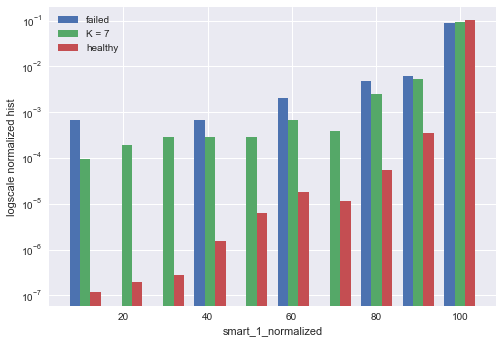

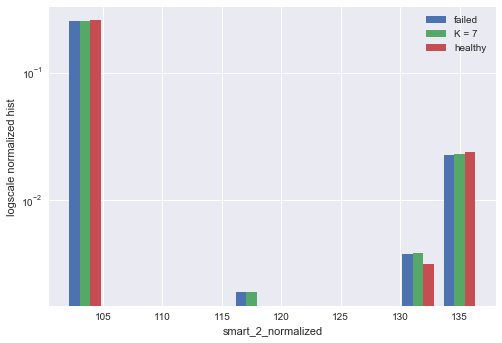

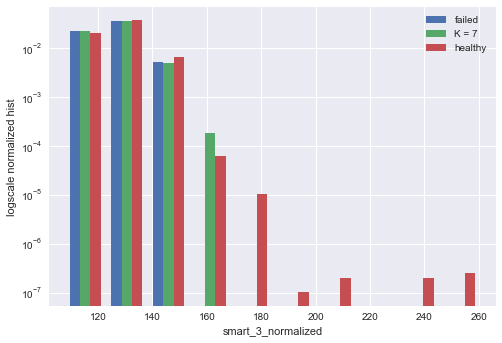

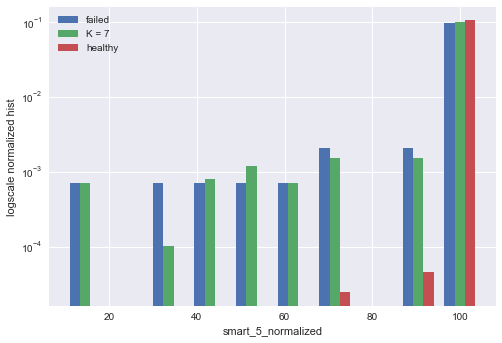

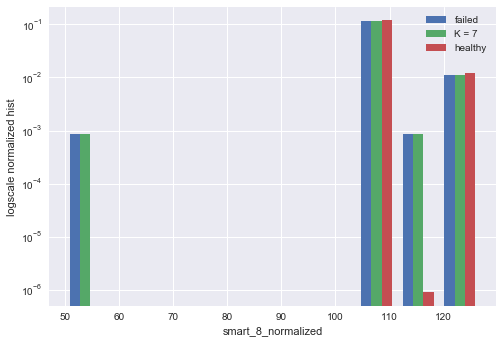

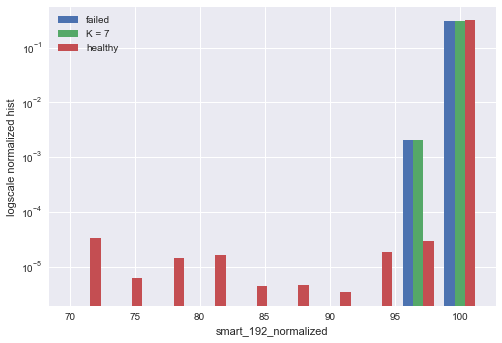

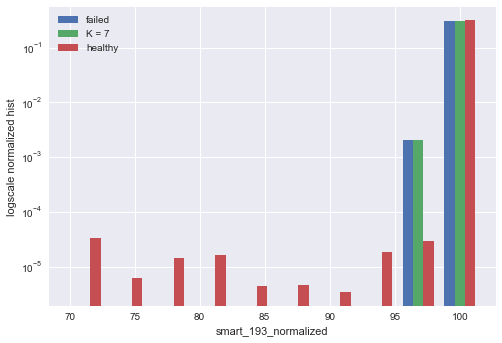

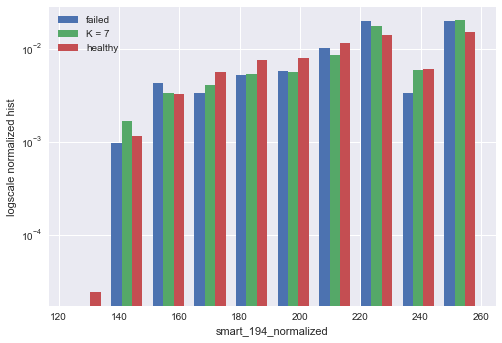

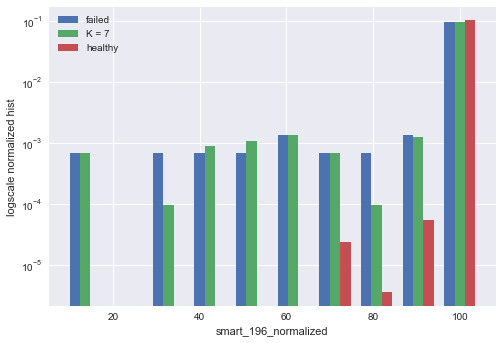

In [9]:
# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    dfh1 = df_failure.loc[(slice(None),slice(None)), smart_metric].values
    dfh2 = df_failure_K.loc[(slice(None),slice(None)), smart_metric].values
    dfh3 = df_healthy.loc[(slice(None),slice(None)), smart_metric].values

    fig, ax = CompareHistograms(dfh1,dfh2,dfh3, hist_range = (df_smartmetrics.loc['min',smart_metric],df_smartmetrics.loc['max',smart_metric]) )
    
    plt.xlabel(smart_metric)
    plt.ylabel('logscale normalized hist')
    
    plt.yscale('log')
    plt.legend(['failed','K = %s' % K,'healthy'])
    
    plt.show()



### Consider example with ModelName = 'Hitachi HDS722020ALA330', we deduce that:

1) SMART 192 and SMART 193 are identical and one of them can be dropped.

2) SMART 2 and SMART 194 are unlikely to be useful in predicting failures: the distributions are very similar for healthy and failing hard disks.

# Exploratory data analysis 2 :

### We look at the evolution of the SMART metrics as the hard disks approaches the failure.

### A few working questions :

1) Does the SMART metrics worsen abruptly or smoothly as the failure approach?  

2) How many hard-disks failures can be predicted for each SMART metric?

In [10]:
df_failing = df[df['state'] == 'fail'].reset_index()

del df_failing['state']

df_failing['days_to_failure'] = [ (df_serialnumber.date_last[df_failing.iloc[i,0]] - df_failing.iloc[i,1]).days for i in range(df_failing.shape[0])]

del df_failing['date']
del df_failing['failure']

df_failing.head()

,serial_number,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_5_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,days_to_failure
0,JK1101B8GA8DAZ,98.0,100.0,114.0,100.0,100.0,100.0,100.0,230.0,100.0,266
1,JK1101B8GA8DAZ,97.0,100.0,114.0,100.0,100.0,100.0,100.0,230.0,100.0,265
2,JK1101B8GA8DAZ,99.0,100.0,114.0,100.0,100.0,100.0,100.0,230.0,100.0,264
3,JK1101B8GA8DAZ,96.0,100.0,114.0,100.0,100.0,100.0,100.0,230.0,100.0,263
4,JK1101B8GA8DAZ,96.0,100.0,114.0,100.0,100.0,100.0,100.0,230.0,100.0,262


In [11]:
perc_min = df_failing.groupby('days_to_failure')[smart_metrics].min()
perc_005 = df_failing.groupby('days_to_failure')[smart_metrics].quantile(.005)
perc_010 = df_failing.groupby('days_to_failure')[smart_metrics].quantile(.01)
perc_050 = df_failing.groupby('days_to_failure')[smart_metrics].quantile(.05)
perc_100 = df_failing.groupby('days_to_failure')[smart_metrics].quantile(.1)
perc_500 = df_failing.groupby('days_to_failure')[smart_metrics].quantile(.5)
perc_max = df_failing.groupby('days_to_failure')[smart_metrics].max()


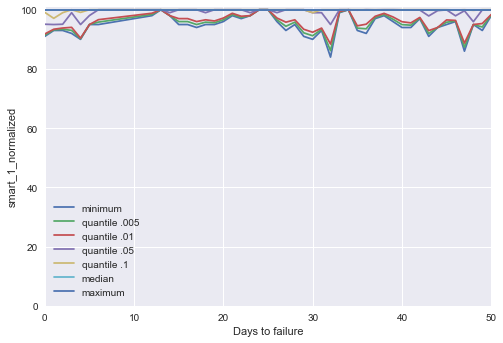

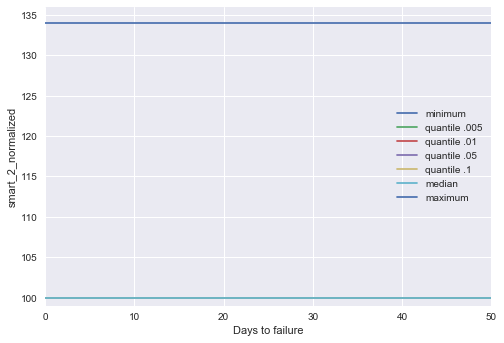

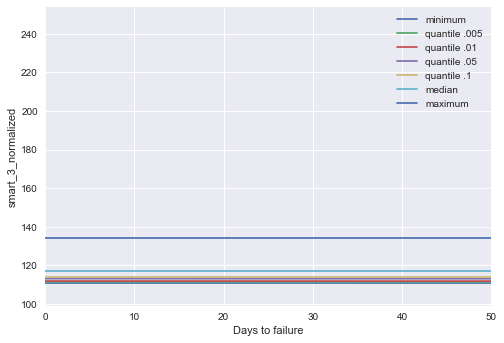

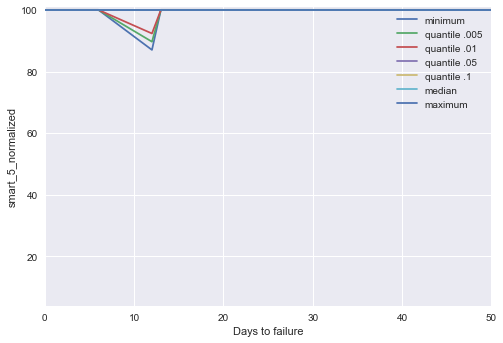

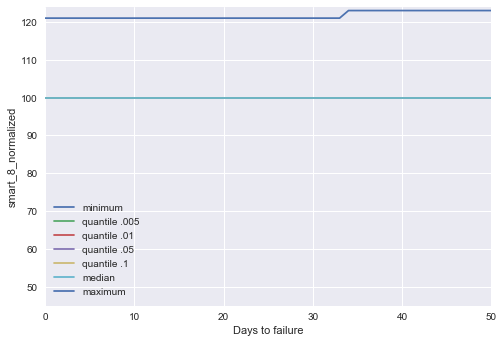

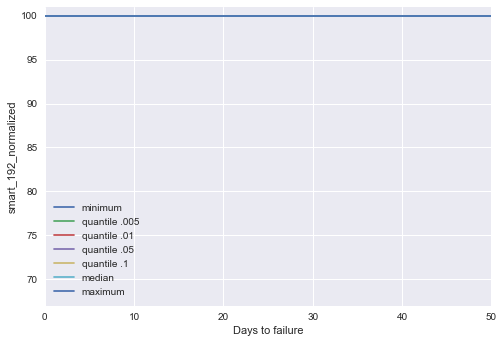

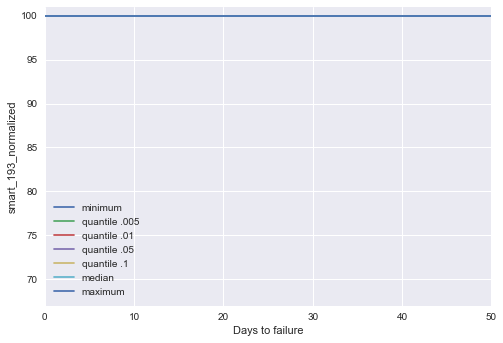

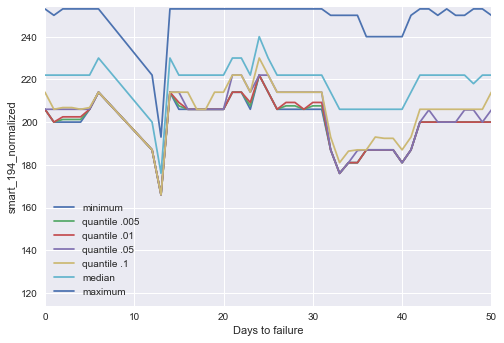

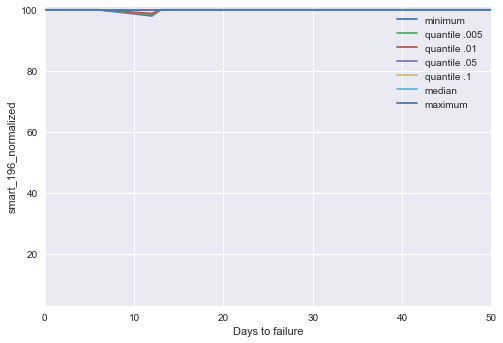

In [31]:
# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    _ = plt.plot(perc_min[smart_metric])
    _ = plt.plot(perc_005[smart_metric])
    _ = plt.plot(perc_010[smart_metric])
    _ = plt.plot(perc_050[smart_metric])
    _ = plt.plot(perc_100[smart_metric])
    _ = plt.plot(perc_500[smart_metric])
    _ = plt.plot(perc_max[smart_metric])


    plt.axis( [0, 50, df_smartmetrics.loc['min',smart_metric] - 1, df_smartmetrics.loc['max',smart_metric] + 1] )
    plt.xlabel('Days to failure')
    plt.ylabel(smart_metric)
    plt.legend(['minimum',
                'quantile .005',
                'quantile .01',
                'quantile .05',
                'quantile .1',
                'median',
                'maximum'])
    
    plt.show()


### Consider example with ModelName = 'Hitachi HDS722020ALA330', we deduce that:

1) SMART 1, 5, and 196 metrics drop about 15 days prior to the failure of an hard disk.

2) Roughly 1% (SMART 1) and 5% (SMART 5 and 196) of the hard disk failures can be predicted.


# Exploratory data analysis 3 :

### We look at the evolution of the SMART metrics as the life of the hard disk increases.

### A few working questions :

1) Does the SMART metrics worsen as the time passes? Is age a factor in the outcome of the SMART metrics?   


In [13]:
df_reset = df.reset_index()
df_present = df_reset[df_reset['date'] == '2015-01-01']

set_of_present_serialnumbers = set(df_present['serial_number'].values)

df_reset['present'] = df_reset.serial_number.apply(lambda x : x in set_of_present_serialnumbers)

df_nonpresent = df_reset[df_reset['present'] == False].reset_index()

df_nonpresent['days_active'] = [ (df_nonpresent.iloc[i,2] - df_serialnumber.date_first[df_nonpresent.iloc[i,1]]).days for i in range(df_nonpresent.shape[0])]

df_nonpresent.head()

,index,serial_number,date,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_5_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,state,present,days_active
0,28081,JK1101B8KKP69Z,2015-03-26,0,100.0,100.0,116.0,100.0,100.0,100.0,100.0,240.0,100.0,fail,False,0
1,28082,JK1101B8KKP69Z,2015-03-27,0,100.0,100.0,116.0,100.0,100.0,100.0,100.0,240.0,100.0,fail,False,1
2,28083,JK1101B8KKP69Z,2015-03-28,0,100.0,100.0,116.0,100.0,100.0,100.0,100.0,240.0,100.0,fail,False,2
3,28084,JK1101B8KKP69Z,2015-03-29,0,100.0,100.0,116.0,100.0,100.0,100.0,100.0,240.0,100.0,fail,False,3
4,28085,JK1101B8KKP69Z,2015-03-30,0,100.0,100.0,116.0,100.0,100.0,100.0,100.0,240.0,100.0,fail,False,4


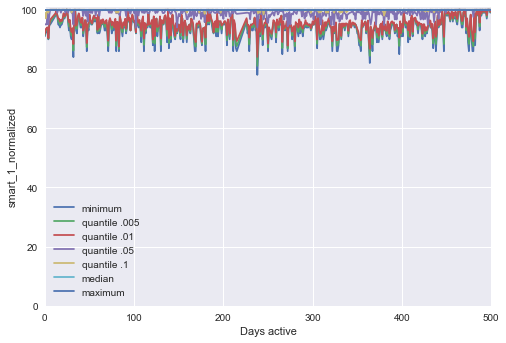

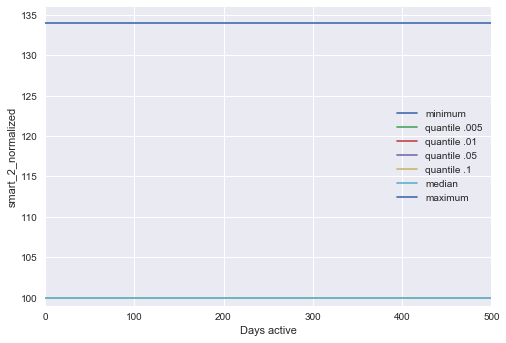

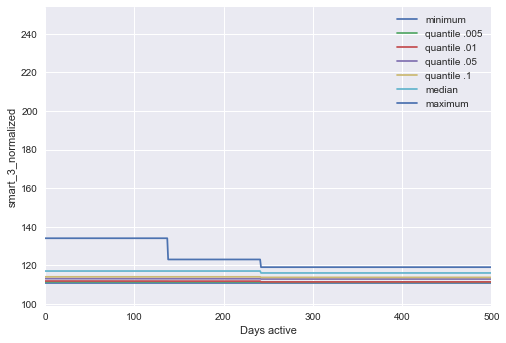

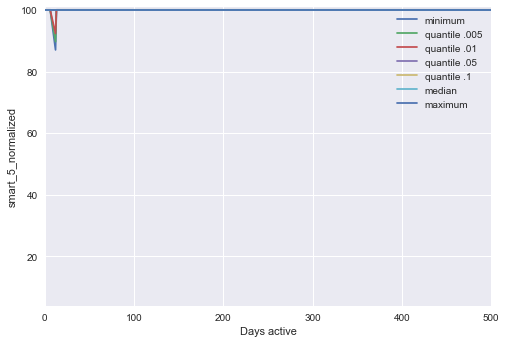

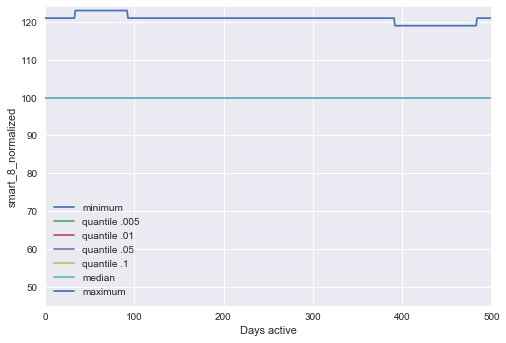

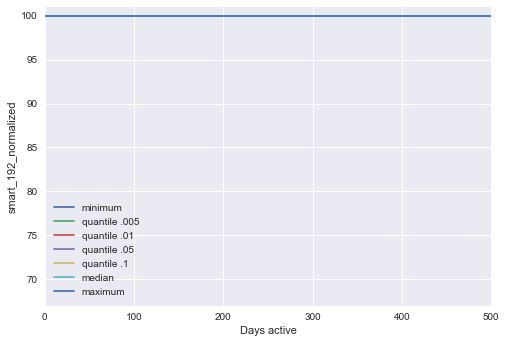

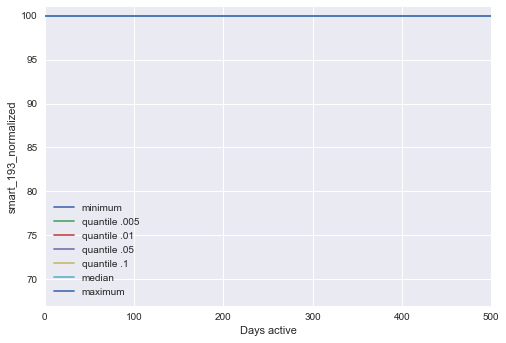

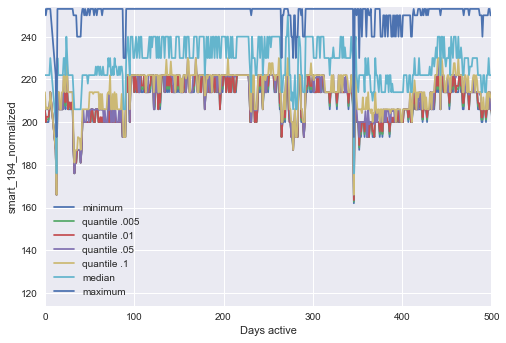

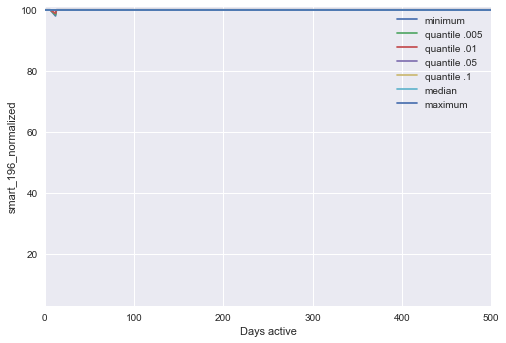

In [14]:
perc_min = df_nonpresent.groupby('days_active')[smart_metrics].min()
perc_005 = df_nonpresent.groupby('days_active')[smart_metrics].quantile(.005)
perc_010 = df_nonpresent.groupby('days_active')[smart_metrics].quantile(.01)
perc_050 = df_nonpresent.groupby('days_active')[smart_metrics].quantile(.05)
perc_100 = df_nonpresent.groupby('days_active')[smart_metrics].quantile(.1)
perc_500 = df_nonpresent.groupby('days_active')[smart_metrics].quantile(.5)
perc_max = df_nonpresent.groupby('days_active')[smart_metrics].max()

# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    _ = plt.plot(perc_min[smart_metric])
    _ = plt.plot(perc_005[smart_metric])
    _ = plt.plot(perc_010[smart_metric])
    _ = plt.plot(perc_050[smart_metric])
    _ = plt.plot(perc_100[smart_metric])
    _ = plt.plot(perc_500[smart_metric])
    _ = plt.plot(perc_max[smart_metric])


    plt.axis( [0, 500, df_smartmetrics.loc['min',smart_metric] - 1, df_smartmetrics.loc['max',smart_metric] + 1] )
    plt.xlabel('Days active')
    plt.ylabel(smart_metric)
    plt.legend(['minimum',
                'quantile .005',
                'quantile .01',
                'quantile .05',
                'quantile .1',
                'median',
                'maximum'])
    
    plt.show()

### Consider example with ModelName = 'Hitachi HDS722020ALA330', we deduce that:

1) The most relevant SMART metrics 1, 5, and 196 remain quite high for the first 500 days.


# Exploratory data analysis 4 :

### What can we say about the 'wrong entries ?

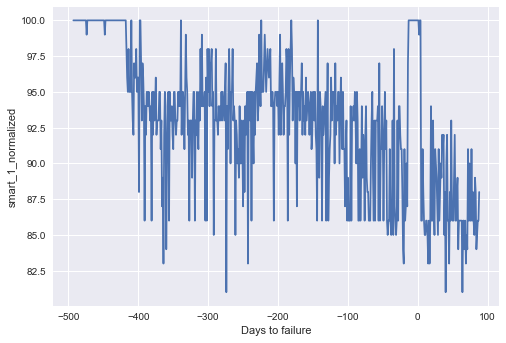

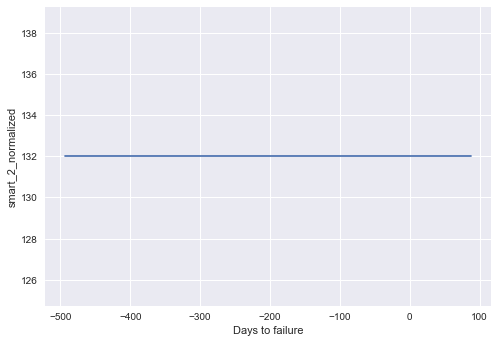

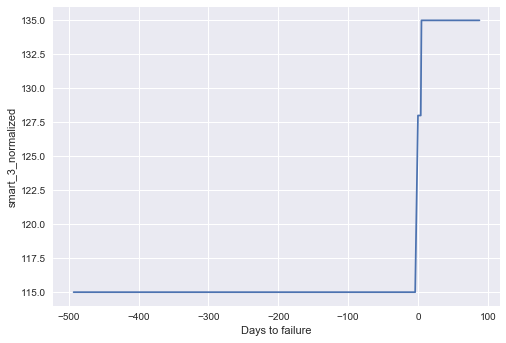

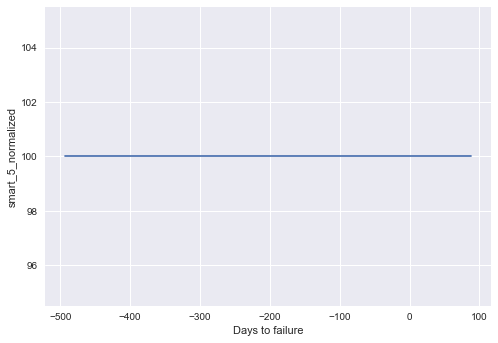

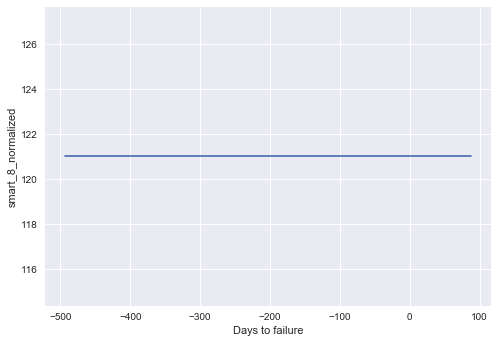

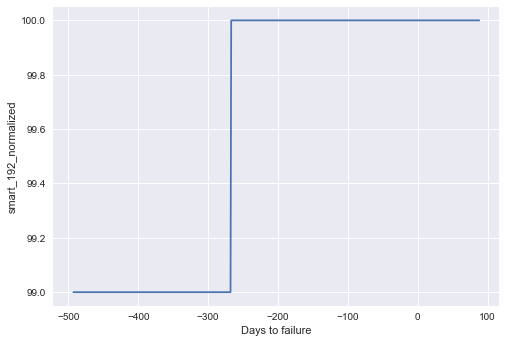

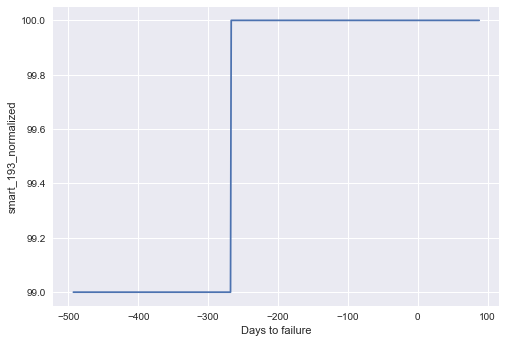

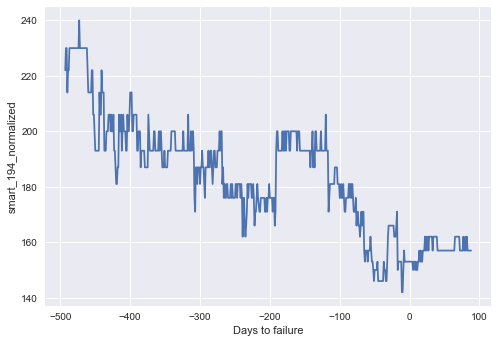

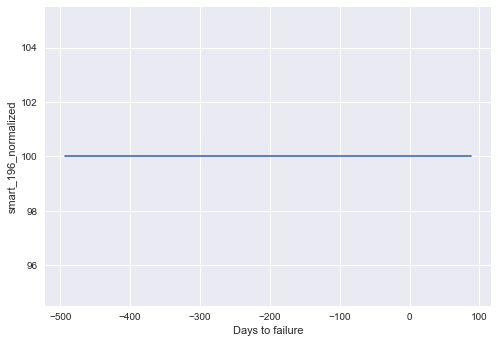

In [32]:
wrong_sn = df_serialnumber[df_serialnumber['state'] == 'wrong'].index

#df.loc['JK1101B9JPJ4NF']
df_wrong = df.loc[wrong_sn].reset_index()

df_wrong['days_to_failure'] = [ (df_serialnumber.date_failure[df_wrong.iloc[i,0]] - df_wrong.iloc[i,1]).days for i in range(df_wrong.shape[0])]

for smart_metric in smart_metrics :

    _ = plt.plot(df_wrong['days_to_failure'],df_wrong[smart_metric])

    plt.xlabel('Days to failure')
    plt.ylabel(smart_metric)
    
    plt.show()
